# SBaC Term Project: Predictive Air Handling Unit Valve Leakage
## Megan McHugh

### Load Packages

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import math
import itertools
import pickle

from matplotlib.patches import Patch
from sklearn import (tree, svm, neighbors, neural_network, ensemble, linear_model, naive_bayes)
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score)
from sklearn.utils import resample
from sklearn.model_selection import (cross_validate, GridSearchCV, train_test_split, KFold,
                                     TimeSeriesSplit, ShuffleSplit, StratifiedKFold, 
                                     GroupShuffleSplit, GroupKFold, StratifiedShuffleSplit)

%matplotlib inline

### Read Data

In [9]:
# preprocessed data in R. valve = 0. colinear columns are removed. near zero variance columns (AHU) is removed.
chw = pd.read_csv('chw_data.csv')
stm = pd.read_csv('stm_data.csv')

# Number of rows and columns
print("chw shape:",chw.shape)
print("stm shape:",stm.shape)

chw shape: (108129, 10)
stm shape: (468886, 10)


In [26]:
display('CHW Data', chw.head(),
       'STM Data', stm.head())

'CHW Data'

,BldgType,Month,Day,Hour,Fan,MAT,MAH,SAT,SPT,Leakage
0,2,4,2,6,20,70,52,51,58,1
1,2,4,2,20,20,71,52,57,58,1
2,2,4,2,21,20,71,52,55,58,1
3,2,4,2,21,20,71,52,57,58,1
4,2,4,3,5,20,71,52,56,58,1


'STM Data'

,BldgType,Month,Day,Hour,Fan,MAT,MAH,SAT,SPT,Leakage
0,5,8,6,0,63,73,52,60,60,0
1,5,8,6,0,63,73,52,60,60,0
2,5,8,6,0,62,73,52,60,60,0
3,5,8,6,0,62,73,52,60,60,0
4,5,8,6,1,62,73,52,60,60,0


In [ ]:
f1 = plt.figure(1)
plt.hist(chw['Leakage'], bins = 2)
plt.xlabel('CHW Leakage Flags')

f2 = plt.figure(2)
plt.hist(stm['Leakage'], bins = 2, color = 'red')
plt.xlabel('STM Leakage Flags')

plt.show()

### Predictors/Target Split

In [10]:
# Predictors
X_chw = chw.iloc[:, 0:9]
X_stm = stm.iloc[:, 0:9]

# Targets
Y_chw = chw['Leakage']
Y_stm = stm['Leakage']

# View
display('CHW Predictors', X_chw.head(),
       'STM Predictors', X_stm.head(),
       'CHW Target', Y_chw.head(),
       'STM Target', Y_stm.head())

'CHW Predictors'

,BldgType,Month,Day,Hour,Fan,MAT,MAH,SAT,SPT
0,2,4,2,6,20,70,52,51,58
1,2,4,2,20,20,71,52,57,58
2,2,4,2,21,20,71,52,55,58
3,2,4,2,21,20,71,52,57,58
4,2,4,3,5,20,71,52,56,58


'STM Predictors'

,BldgType,Month,Day,Hour,Fan,MAT,MAH,SAT,SPT
0,5,8,6,0,63,73,52,60,60
1,5,8,6,0,63,73,52,60,60
2,5,8,6,0,62,73,52,60,60
3,5,8,6,0,62,73,52,60,60
4,5,8,6,1,62,73,52,60,60


'CHW Target'

0    1
1    1
2    1
3    1
4    1
Name: Leakage, dtype: int64

'STM Target'

0    0
1    0
2    0
3    0
4    0
Name: Leakage, dtype: int64

In [5]:
# Double check target split weight between Leakage flag values
set(Y_chw)
print('CHW',collections.Counter(Y_chw))
set(Y_stm)
print('STM',collections.Counter(Y_stm))

CHW Counter({0: 66252, 1: 41877})
STM Counter({0: 259129, 1: 209757})


### Train/Test/Validation Splits
(60% / 20% / 20%)

In [11]:
# Partial Split/Test Split: 80/20
X_chw_split, X_chw_test, Y_chw_split, Y_chw_test = train_test_split(X_chw, Y_chw, test_size = 0.20, train_size = 0.80)
X_stm_split, X_stm_test, Y_stm_split, Y_stm_test = train_test_split(X_stm, Y_stm, test_size = 0.20, train_size = 0.80)

# Train/Validation Split: 75/25
X_chw_train, X_chw_eval, Y_chw_train, Y_chw_eval = train_test_split(X_chw_split, Y_chw_split, test_size = 0.25, train_size = 0.75)
X_stm_train, X_stm_eval, Y_stm_train, Y_stm_eval = train_test_split(X_stm_split, Y_stm_split, test_size = 0.25, train_size = 0.75)

print("CHW:\n", 
      'X train set:', len(X_chw_train), 'length ~', round(len(X_chw_train)/len(X_chw)*100), '% \n',
      'X test set:', len(X_chw_test), 'length ~', round(len(X_chw_test)/len(X_chw)*100), '% \n',
      'X validation set:', len(X_chw_eval), 'length ~', round(len(X_chw_eval)/len(X_chw)*100), '% \n',
      'Y train set:', len(Y_chw_train), 'length ~', round(len(Y_chw_train)/len(Y_chw)*100), '% \n',
      'Y test set:', len(Y_chw_test), 'length ~', round(len(Y_chw_test)/len(Y_chw)*100), '% \n',
      'Y validation set:', len(Y_chw_eval), 'length ~', round(len(Y_chw_eval)/len(Y_chw)*100), '% \n')
print("STM:\n", 
      'X train set:', len(X_stm_train), 'length ~', round(len(X_stm_train)/len(X_stm)*100), '% \n',
      'X test set:', len(X_stm_test), 'length ~', round(len(X_stm_test)/len(X_stm)*100), '% \n',
      'X validation set:', len(X_stm_eval), 'length ~', round(len(X_stm_eval)/len(X_stm)*100), '% \n',
      'Y train set:', len(Y_stm_train), 'length ~', round(len(Y_stm_train)/len(Y_stm)*100), '% \n',
      'Y test set:', len(Y_stm_test), 'length ~', round(len(Y_stm_test)/len(Y_stm)*100), '% \n',
      'Y validation set:', len(Y_stm_eval), 'length ~', round(len(Y_stm_eval)/len(Y_stm)*100), '%')

CHW:
 X train set: 64877 length ~ 60 % 
 X test set: 21626 length ~ 20 % 
 X validation set: 21626 length ~ 20 % 
 Y train set: 64877 length ~ 60 % 
 Y test set: 21626 length ~ 20 % 
 Y validation set: 21626 length ~ 20 % 

STM:
 X train set: 281331 length ~ 60 % 
 X test set: 93778 length ~ 20 % 
 X validation set: 93777 length ~ 20 % 
 Y train set: 281331 length ~ 60 % 
 Y test set: 93778 length ~ 20 % 
 Y validation set: 93777 length ~ 20 %


### Generate and Fit Models

In [14]:
# Create classification models for chw and stm
chw_m1 = stm_m1 = linear_model.LogisticRegression()
chw_m2 = stm_m2 = neighbors.KNeighborsClassifier(n_neighbors=2)
chw_m3 = stm_m3 = svm.LinearSVC()
chw_m4 = stm_m4 = naive_bayes.GaussianNB()
chw_m5 = stm_m5 = tree.DecisionTreeClassifier()
chw_m6 = stm_m6 = neural_network.MLPClassifier()
chw_m7 = stm_m7 = ensemble.BaggingClassifier()
chw_m8 = stm_m8 = ensemble.RandomForestClassifier()
chw_m9 = stm_m9 = ensemble.AdaBoostClassifier()
chw_m10 = stm_m10 = ensemble.GradientBoostingClassifier()

In [15]:
# Model lists
chw_models = [chw_m1,chw_m2,chw_m3,chw_m4,chw_m5,chw_m6,chw_m7,chw_m8,chw_m9,chw_m10]
stm_models = [stm_m1,stm_m2,stm_m3,stm_m4,stm_m5,stm_m6,stm_m7,stm_m8,stm_m9,stm_m10]

model_names = ['LogisticRegression', 'KNN', 'LinearSVC', 'GaussianNB', 'DecisionTree',
                    'MLP', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting']

In [16]:
# Train models
for i in range(len(chw_models)):
    chw_models[i].fit(X_chw_train, Y_chw_train)
    stm_models[i].fit(X_stm_train, Y_stm_train)

In [ ]:
chw_m5 = stm_m5 = tree.DecisionTreeClassifier()


### Evaluate Models

In [17]:
# Predictions
chw_preds = []
stm_preds = []

for i in range(len(chw_models)):
    chw_preds.append(chw_models[i].predict(X_chw_test))
    stm_preds.append(stm_models[i].predict(X_stm_test))
    print(model_names[i],'accuracy score:\n',
      'CHW:', round(accuracy_score(Y_chw_test, chw_preds[i])*100, 2), '%', '\n',
      'STM:', round(accuracy_score(Y_stm_test, stm_preds[i])*100, 2), '%', '\n')

LogisticRegression accuracy score:
 CHW: 61.26 % 
 STM: 74.33 % 

KNN accuracy score:
 CHW: 52.48 % 
 STM: 96.76 % 

LinearSVC accuracy score:
 CHW: 61.14 % 
 STM: 59.03 % 

GaussianNB accuracy score:
 CHW: 61.14 % 
 STM: 74.25 % 

DecisionTree accuracy score:
 CHW: 60.62 % 
 STM: 97.29 % 

MLP accuracy score:
 CHW: 59.74 % 
 STM: 94.89 % 

Bagging accuracy score:
 CHW: 60.39 % 
 STM: 97.43 % 

RandomForest accuracy score:
 CHW: 59.57 % 
 STM: 97.52 % 

AdaBoost accuracy score:
 CHW: 60.97 % 
 STM: 85.12 % 

GradientBoosting accuracy score:
 CHW: 60.71 % 
 STM: 93.87 % 



In [ ]:
# Plot accuracy scores
chw_acc_scores = []
stm_acc_scores = []

for i in range(len(chw_preds)):
    chw_acc_scores.append(accuracy_score(Y_chw_test, chw_preds[i])*100)
    stm_acc_scores.append(accuracy_score(Y_stm_test, stm_preds[i])*100)

N = 10

fig1, ax1 = plt.subplots(figsize=(9,6))

ind = np.arange(N)    # the x locations for the groups
p1 = ax1.scatter(ind, chw_acc_scores, color='blue')
p2 = ax1.scatter(ind, stm_acc_scores, color='red')

ax1.set_title('Leakage Model Accuracy Scores by Classifier')
ax1.set_xticks(ind)
ax1.set_yticks(np.arange(50, 100, 5))
ax1.set_xticklabels(('Logistic \nRegression', 'KNN', 'Linear \nSVC', 'Gaussian \nNB', 'Decision \nTree',
                    'MLP', 'Bagging', 'Random \nForest', 'AdaBoost', 'Gradient \nBoosting'))

ax1.legend((p1, p2), ('Chilled Water Model Fits', 'Steam Model Fits'), loc='upper center', 
           bbox_to_anchor=(0.5, -0.08), fancybox=True, ncol=2)
ax1.autoscale_view()

plt.grid(True)
plt.show()

In [38]:
# Define confusion matrix plot
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, size=(10,10))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90, verticalalignment="center")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()


In [ ]:
# Plot confusion matrices
class_names = ['Normal','Leakage']

titles = ['Logistic Regression \nNormalized Confusion Matrix', 
          'KNN \nNormalized Confusion Matrix', 
          'Linear SVC \nNormalized Confusion Matrix', 
          'Gaussian NB \nNormalized Confusion Matrix', 
          'Decision Tree \nNormalized Confusion Matrix',
          'MLP \nNormalized Confusion Matrix', 
          'Bagging \nNormalized Confusion Matrix', 
          'Random Forest \nNormalized Confusion Matrix', 
          'AdaBoost \nNormalized Confusion Matrix', 
          'Gradient Boosting \nNormalized Confusion Matrix']

w = 10
h = 10
columns = 4
rows = 5

np.set_printoptions(precision=2)

for ii in range(len(chw_preds)):
    chw_cnf_matrix = confusion_matrix(Y_chw_test, chw_preds[ii])
    stm_cnf_matrix = confusion_matrix(Y_stm_test, stm_preds[ii])
    print(chw_cnf_matrix)
    print(stm_cnf_matrix)
#     fig = plt.figure()
#     fig.add_subplot(rows, columns, ii+1)

#     plot_confusion_matrix(chw_cnf_matrix, classes=class_names, 
#                           normalize=True, title=" ".join(['Chilled Water',titles[ii]]))

# plt.show()

# for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
# plt.show()

In [ ]:
# Classification reports
for i in range(len(chw_preds)):
    print(model_names[i],'classification reports:\n',
          'CHW:\n', classification_report(Y_chw_test, chw_preds[i]),'\n',
          'STM:\n', classification_report(Y_stm_test, stm_preds[i]),'\n')

## Cross Validation

In [18]:
np.random.seed(1004)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 5

In [19]:
# Model lists
chw_models = [chw_m1,chw_m2,chw_m3,chw_m4,chw_m5,chw_m6,chw_m7,chw_m8,chw_m9,chw_m10]
stm_models = [stm_m1,stm_m2,stm_m3,stm_m4,stm_m5,stm_m6,stm_m7,stm_m8,stm_m9,stm_m10]

model_names = ['LogisticRegression', 'kNN', 'LinearSVC', 'GaussianNB', 'DecisionTree',
                    'MLP', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting']

In [ ]:
chw_cvs = []
stm_cvs = []

chw_test_scores = []
stm_test_scores = []

for i in range(len(chw_models)):
    chw_cvs.append(cross_validate(chw_models[i], X_chw_train, Y_chw_train, scoring = 'precision_macro', cv = 5))
    stm_cvs.append(cross_validate(stm_models[i], X_stm_train, Y_stm_train, scoring = 'precision_macro', cv = 5))
    chw_test_scores.append(np.mean(chw_cvs[i]['test_score']))
    stm_test_scores.append(np.mean(stm_cvs[i]['test_score']))
    print(model_names[i],'cross validation mean test scores:\n',
          'CHW:\n', round(chw_test_scores[i]*100, 2), '%','\n',
          'STM:\n', round(stm_test_scores[i]*100, 2), '%','\n')

LogisticRegression cross validation mean test scores:
 CHW:
 97.26 % 
 STM:
 70.66 % 

kNN cross validation mean test scores:
 CHW:
 91.36 % 
 STM:
 67.06 % 



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# Plot test scores
N = 10

fig1, ax1 = plt.subplots(figsize=(9,6))

ind = np.arange(N)    # the x locations for the groups
p1 = ax1.scatter(ind, chw_test_scores, color='blue')
p2 = ax1.scatter(ind, stm_test_scores, color='red')

ax1.set_title('Leakage Model Cross Validation Mean Test Scores by Classifier')
ax1.set_xticks(ind)
ax1.set_xticklabels(('Logistic \nRegression', 'kNN', 'Linear \nSVC', 'Gaussian \nNB', 'Decision \nTree',
                    'MLP', 'Bagging', 'Random \nForest', 'AdaBoost', 'Gradient \nBoosting'))

ax1.legend((p1, p2), ('Chilled Water Model Fits', 'Steam Model Fits'), loc='upper center', 
           bbox_to_anchor=(0.5, -0.08), fancybox=True, ncol=2)
ax1.autoscale_view()

plt.grid(True)
plt.show()

## Grid Search

__Logistic Regression__

In [54]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
m1_params = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
chw_m1_GS = GridSearchCV(chw_m1, m1_params, cv=5, verbose=0)
stm_m1_GS = GridSearchCV(stm_m1, m1_params, cv=5, verbose=0)

In [55]:
# Fit grid search
chw_m1_GS_fit = chw_m1_GS.fit(X_chw_train, Y_chw_train)
stm_m1_GS_fit = stm_m1_GS.fit(X_stm_train, Y_stm_train)

# View best hyperparameters
print('Best CHW Penalty:', chw_m1_GS_fit.best_estimator_.get_params()['penalty'])
print('Best CHW C:', chw_m1_GS_fit.best_estimator_.get_params()['C'])
print('Best STM Penalty:', stm_m1_GS_fit.best_estimator_.get_params()['penalty'])
print('Best STM C:', stm_m1_GS_fit.best_estimator_.get_params()['C'])

Best CHW Penalty: l2
Best CHW C: 21.544346900318832
Best STM Penalty: l2
Best STM C: 1.0


In [56]:
# Check Model Results
print("CHW Logistic Regression Hyperparameter Tuning Results:\n", 
      'Best parameters:', chw_m1_GS.best_params_, '\n',
      'Best score:', chw_m1_GS.best_score_, '\n',
      'Best estimator:', chw_m1_GS.best_estimator_, '\n')
print("STM Logistic Regression Hyperparameter Tuning Results:\n", 
      'Best parameters:', stm_m1_GS.best_params_, '\n',
      'Best score:', stm_m1_GS.best_score_, '\n',
      'Best estimator:', stm_m1_GS.best_estimator_, '\n')

CHW Logistic Regression Hyperparameter Tuning Results:
 Best parameters: {'C': 21.544346900318832, 'penalty': 'l2'} 
 Best score: 0.9821662530634894 
 Best estimator: LogisticRegression(C=21.544346900318832, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 

STM Logistic Regression Hyperparameter Tuning Results:
 Best parameters: {'C': 1.0, 'penalty': 'l2'} 
 Best score: 0.743743135310364 
 Best estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 



ValueError: x and y must be the same size

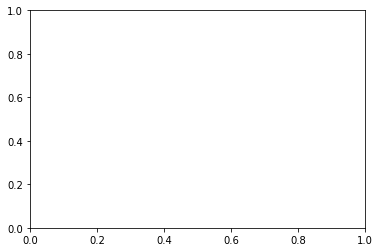

In [57]:
# Plots
plt.scatter(chw_m1_GS.cv_results_['mean_test_score'])
plt.scatter(stm_m1_GS.cv_results_['mean_test_score'], color='red')
plt.title("Logistic Regression Grid Search Hyperparameter Mean Test Scores")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# chw_m1_GS_file = 'chw_m1_GS'
# chw_m1_GS_out = open(chw_m1_GS_file,'wb')
# pickle.dump(chw_m1_GS,chw_m1_GS_out)
# chw_m1_GS_out.close()

# chw_m1_GS_fit_file = 'chw_m1_GS_fit'
# chw_m1_GS_fit_out = open(chw_m1_GS_fit_file,'wb')
# pickle.dump(chw_m1_GS_fit,chw_m1_GS_fit_out)
# chw_m1_GS_fit_out.close()

# stm_m1_GS_file = 'stm_m1_GS'
# stm_m1_GS_out = open(stm_m1_GS_file,'wb')
# pickle.dump(stm_m1_GS,stm_m1_GS_out)
# stm_m1_GS_out.close()

# stm_m1_GS_fit_file = 'stm_m1_GS_fit'
# stm_m1_GS_fit_out = open(stm_m1_GS_fit_file,'wb')
# pickle.dump(stm_m1_GS_fit,stm_m1_GS_fit_out)
# stm_m1_GS_fit_out.close()

__kNN__

In [58]:
# Parameter options
m2_params = {'n_neighbors':range(1,21)}

# Grid Search
chw_m2_GS = GridSearchCV(chw_m2, m2_params, cv = 5, scoring = 'precision_macro')
stm_m2_GS = GridSearchCV(stm_m2, m2_params, cv = 5, scoring = 'precision_macro')

In [ ]:
# Fit Models
chw_m2_GS_fit = chw_m2_GS.fit(X_chw_train, Y_chw_train)
stm_m2_GS_fit = stm_m2_GS.fit(X_stm_train, Y_stm_train)

# Model Results
print("CHW kNN Hyperparameter Tuning Results:\n", 
      'Best parameters:', chw_m2_GS.best_params_, '\n',
      'Best score:', chw_m2_GS.best_score_, '\n',
      'Best estimator:', chw_m2_GS.best_estimator_, '\n')
print("STM kNN Hyperparameter Tuning Results:\n", 
      'Best parameters:', stm_m2_GS.best_params_, '\n',
      'Best score:', stm_m2_GS.best_score_, '\n',
      'Best estimator:', stm_m2_GS.best_estimator_, '\n')

In [ ]:
plt.scatter(x = range(1,21), y = chw_m2_GS.cv_results_['mean_test_score'])
plt.scatter(x = range(1,21), y = stm_m2_GS.cv_results_['mean_test_score'], color='red')
plt.title("kNN Grid Search Hyperparameter Mean Test Scores")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# chw_m2_GS_file = 'chw_m2_GS'
# chw_m2_GS_out = open(chw_m2_GS_file,'wb')
# pickle.dump(chw_m2_GS,chw_m2_GS_out)
# chw_m2_GS_out.close()

# chw_m2_GS_fit_file = 'chw_m2_GS_fit'
# chw_m2_GS_fit_out = open(chw_m2_GS_fit_file,'wb')
# pickle.dump(chw_m2_GS_fit,chw_m2_GS_fit_out)
# chw_m2_GS_fit_out.close()

# stm_m2_GS_file = 'stm_m2_GS'
# stm_m2_GS_out = open(stm_m2_GS_file,'wb')
# pickle.dump(stm_m2_GS,stm_m2_GS_out)
# stm_m2_GS_out.close()

# stm_m2_GS_fit_file = 'stm_m2_GS_fit'
# stm_m2_GS_fit_out = open(stm_m2_GS_fit_file,'wb')
# pickle.dump(stm_m2_GS_fit,stm_m2_GS_fit_out)
# stm_m2_GS_fit_out.close()

__Linear SVC__

In [11]:
# Parameter options
m3_params = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

# Grid Search
chw_m3_RS = RandomizedSearchCV(chw_m3, m3_params, cv = 5, scoring = 'precision_macro', n_iter=10)
stm_m3_RS = RandomizedSearchCV(stm_m3, m3_params, cv = 5, scoring = 'precision_macro', n_iter=10)

In [12]:
# Fit grid search
chw_m3_RS.fit(X_chw_train, Y_chw_train)
stm_m3_RS.fit(X_stm_train, Y_stm_train)

# View best hyperparameters
print('Best CHW gamma:', chw_m3_RS_fit.best_estimator_.get_params()['gamma'])
print('Best CHW kernel:', chw_m3_RS_fit.best_estimator_.get_params()['kernel'])
print('Best CHW C:', chw_m3_RS_fit.best_estimator_.get_params()['C'])
print('Best STM gamma:', stm_m3_RS_fit.best_estimator_.get_params()['gamma'])
print('Best STM kernel:', stm_m3_RS_fit.best_estimator_.get_params()['kernel'])
print('Best STM C:', stm_m3_RS_fit.best_estimator_.get_params()['C'])

ValueError: Invalid parameter kernel for estimator LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
# Check Model Results
print("CHW Linear SVC Hyperparameter Tuning Results:\n", 
      'Best parameters:', chw_m3_RS.best_params_, '\n',
      'Best score:', chw_m3_RS.best_score_, '\n',
      'Best estimator:', chw_m3_RS.best_estimator_, '\n')
print("STM Linear SVC Hyperparameter Tuning Results:\n", 
      'Best parameters:', stm_m3_RS.best_params_, '\n',
      'Best score:', stm_m3_RS.best_score_, '\n',
      'Best estimator:', stm_m3_RS.best_estimator_, '\n')

In [ ]:
plt.scatter(x = range(1,1001), y = chw_m3_RS.cv_results_['mean_test_score'])
plt.scatter(x = range(1,1001), y = stm_m3_RS.cv_results_['mean_test_score'], color = 'red')
plt.title("Linear SVC Grid Search Hyperparameter Mean Test Scores")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# chw_m3_GS_file = 'chw_m3_GS'
# chw_m3_GS_out = open(chw_m3_GS_file,'wb')
# pickle.dump(chw_m3_GS,chw_m3_GS_out)
# chw_m3_GS_out.close()

# chw_m3_GS_fit_file = 'chw_m3_GS_fit'
# chw_m3_GS_fit_out = open(chw_m3_GS_fit_file,'wb')
# pickle.dump(chw_m3_GS_fit,chw_m3_GS_fit_out)
# chw_m3_GS_fit_out.close()

# stm_m3_GS_file = 'stm_m3_GS'
# stm_m3_GS_out = open(stm_m3_GS_file,'wb')
# pickle.dump(stm_m3_GS,stm_m3_GS_out)
# stm_m3_GS_out.close()

# stm_m3_GS_fit_file = 'stm_m3_GS_fit'
# stm_m3_GS_fit_out = open(stm_m3_GS_fit_file,'wb')
# pickle.dump(stm_m3_GS_fit,stm_m3_GS_fit_out)
# stm_m3_GS_fit_out.close()

__Decision Tree__

In [ ]:
m5_params = {'min_samples_split' : range(10,500,20), 'max_depth': range(1,20,2)}

chw_m5_GS = GridSearchCV(chw_m5, m5_params, cv=5, scoring='precision_macro')
stm_m5_GS = GridSearchCV(stm_m5, m5_params, cv=5, scoring='precision_macro')

In [ ]:
chw_m5_GS_fit = chw_m5_GS.fit(X_chw_train, Y_chw_train)
stm_m5_GS_fit = stm_m5_GS.fit(X_stm_train, Y_stm_train)

print('Best CHW min_samples_split:', chw_m3_GS_fit.best_estimator_.get_params()['min_samples_split'])
print('Best CHW max_depth:', chw_m3_GS_fit.best_estimator_.get_params()['max_depth'])
print('Best STM min_samples_split:', stm_m3_GS_fit.best_estimator_.get_params()['min_samples_split'])
print('Best STM max_depth:', stm_m3_GS_fit.best_estimator_.get_params()['max_depth'])

In [ ]:
print("CHW Decision Tree Hyperparameter Tuning Results:\n", 
      'Best parameters:', chw_m5_GS.best_params_, '\n',
      'Best score:', chw_m5_GS.best_score_, '\n',
      'Best estimator:', chw_m5_GS.best_estimator_, '\n')
print("STM Decision Tree Hyperparameter Tuning Results:\n", 
      'Best parameters:', stm_m5_GS.best_params_, '\n',
      'Best score:', stm_m5_GS.best_score_, '\n',
      'Best estimator:', stm_m5_GS.best_estimator_, '\n')

In [ ]:
plt.scatter(x = range(1,501), y = chw_m5_GS.cv_results_['mean_test_score'])
plt.scatter(x = range(1,501), y = stm_m5_GS.cv_results_['mean_test_score'], color = 'red')
plt.title("Decision Tree Grid Search Hyperparameter Mean Test Scores")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# chw_m5_GS_file = 'chw_m5_GS'
# chw_m5_GS_out = open(chw_m5_GS_file,'wb')
# pickle.dump(chw_m5_GS,chw_m5_GS_out)
# chw_m5_GS_out.close()

# chw_m5_GS_fit_file = 'chw_m5_GS_fit'
# chw_m5_GS_fit_out = open(chw_m5_GS_fit_file,'wb')
# pickle.dump(chw_m5_GS_fit,chw_m5_GS_fit_out)
# chw_m5_GS_fit_out.close()

# stm_m5_GS_file = 'stm_m5_GS'
# stm_m5_GS_out = open(stm_m5_GS_file,'wb')
# pickle.dump(stm_m5_GS,stm_m5_GS_out)
# stm_m5_GS_out.close()

# stm_m5_GS_fit_file = 'stm_m5_GS_fit'
# stm_m5_GS_fit_out = open(stm_m5_GS_fit_file,'wb')
# pickle.dump(stm_m5_GS_fit,stm_m5_GS_fit_out)
# stm_m5_GS_fit_out.close()

__MLP Neural Network__

In [15]:
m6_params = {'hidden_layer_sizes':range(1,101,5),'activation':['identity','logistic','tanh','relu']}

In [28]:
chw_m6_RS = RandomizedSearchCV(chw_m6, m6_params, cv=5, scoring = 'precision_macro', n_iter=10)
chw_m6_RS_fit = chw_m6_RS.fit(X_chw_train, Y_chw_train)

print('Best CHW hidden_layer_sizes:', chw_m6_RS_fit.best_estimator_.get_params()['hidden_layer_sizes'])
print('Best CHW activation:', chw_m6_RS_fit.best_estimator_.get_params()['activation'])

Best CHW hidden_layer_sizes: 26
Best CHW activation: relu


In [17]:
stm_m6_RS = RandomizedSearchCV(stm_m6, m6_params, cv=5, scoring = 'precision_macro', n_iter=10)
stm_m6_RS_fit = stm_m6_RS.fit(X_stm_train, Y_stm_train)

print('Best STM hidden_layer_sizes:', stm_m6_RS_fit.best_estimator_.get_params()['hidden_layer_sizes'])
print('Best STM activation:', stm_m6_RS_fit.best_estimator_.get_params()['activation'])

Best STM hidden_layer_sizes: 51
Best STM activation: tanh


In [18]:
# Check Model Results
print("CHW MLP ANN Hyperparameter Tuning Results:\n", 
      'Best parameters:', chw_m6_RS.best_params_, '\n',
      'Best score:', chw_m6_RS.best_score_, '\n',
      'Best estimator:', chw_m6_RS.best_estimator_, '\n')
print("STM MLP ANN Hyperparameter Tuning Results:\n", 
      'Best parameters:', stm_m6_RS.best_params_, '\n',
      'Best score:', stm_m6_RS.best_score_, '\n',
      'Best estimator:', stm_m6_RS.best_estimator_, '\n')

CHW MLP ANN Hyperparameter Tuning Results:
 Best parameters: {'hidden_layer_sizes': 51, 'activation': 'logistic'} 
 Best score: 0.9875137688570418 
 Best estimator: MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=51, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False) 

STM MLP ANN Hyperparameter Tuning Results:
 Best parameters: {'hidden_layer_sizes': 51, 'activation': 'tanh'} 
 Best score: 0.9471430787165506 
 Best estimator: MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=51, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200,

In [19]:
plt.scatter(x = range(1,101), y = chw_m6_RS.cv_results_['mean_test_score'])
plt.scatter(x = range(1,101), y = stm_m6_RS.cv_results_['mean_test_score'], color = 'red')
plt.title("MLP ANN Grid Search Hyperparameter Mean Test Scores")
plt.legend()
plt.show()

AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'

In [ ]:
# chw_m6_GS_file = 'chw_m6_GS'
# chw_m6_GS_out = open(chw_m6_GS_file,'wb')
# pickle.dump(chw_m6_GS,chw_m6_GS_out)
# chw_m6_GS_out.close()

# chw_m6_GS_fit_file = 'chw_m6_GS_fit'
# chw_m6_GS_fit_out = open(chw_m6_GS_fit_file,'wb')
# pickle.dump(chw_m6_GS_fit,chw_m6_GS_fit_out)
# chw_m6_GS_fit_out.close()

# stm_m6_GS_file = 'stm_m6_GS'
# stm_m6_GS_out = open(stm_m6_GS_file,'wb')
# pickle.dump(stm_m6_GS,stm_m6_GS_out)
# stm_m6_GS_out.close()

# stm_m6_GS_fit_file = 'stm_m6_GS_fit'
# stm_m6_GS_fit_out = open(stm_m6_GS_fit_file,'wb')
# pickle.dump(stm_m6_GS_fit,stm_m6_GS_fit_out)
# stm_m6_GS_fit_out.close()

__Bagged Trees__

In [22]:
m7_params = {'base_estimator__max_depth' : [1, 2, 3, 4, 5], 'max_samples' : [0.05, 0.1, 0.2, 0.5]}

chw_m7_RS = RandomizedSearchCV(ensemble.BaggingClassifier(tree.DecisionTreeClassifier(),
                                     n_estimators = 100, max_features = 0.5),
                     m7_params, scoring = 'precision_macro', n_iter=10)
stm_m7_RS = RandomizedSearchCV(ensemble.BaggingClassifier(tree.DecisionTreeClassifier(),
                                     n_estimators = 100, max_features = 0.5),
                     m7_params, scoring = 'precision_macro', n_iter=10)

In [23]:
chw_m7_RS.fit(X_chw_train, Y_chw_train)
stm_m7_RS.fit(X_stm_train, Y_stm_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ..._estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'base_estimator__max_depth': [1, 2, 3, 4, 5], 'max_samples': [0.05, 0.1, 0.2, 0.5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='precision_macro', verbose=0)

In [25]:
# Check Model Results
print("CHW Bagged Trees Hyperparameter Tuning Results:\n", 
      'Best parameters:', chw_m7_RS.best_params_, '\n',
      'Best score:', chw_m7_RS.best_score_, '\n',
      'Best estimator:', chw_m7_RS.best_estimator_, '\n')
print("STM Bagged Trees Hyperparameter Tuning Results:\n", 
      'Best parameters:', stm_m7_RS.best_params_, '\n',
      'Best score:', stm_m7_RS.best_score_, '\n',
      'Best estimator:', stm_m7_RS.best_estimator_, '\n')

CHW Bagged Trees Hyperparameter Tuning Results:
 Best parameters: {'max_samples': 0.05, 'base_estimator__max_depth': 5} 
 Best score: 0.9749824508779769 
 Best estimator: BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.05, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False) 

STM Bagged Trees Hyperparameter Tuning Results:
 Best parameters: {'max_samples': 0.1, 'base_estimator__max_depth': 5} 
 Best score: 0.8796518238992674 
 Best estimator: BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, cri

In [ ]:
# chw_m7_GS_file = 'chw_m7_GS'
# chw_m7_GS_out = open(chw_m7_GS_file,'wb')
# pickle.dump(chw_m7_GS,chw_m7_GS_out)
# chw_m7_GS_out.close()

# chw_m7_GS_fit_file = 'chw_m7_GS_fit'
# chw_m7_GS_fit_out = open(chw_m7_GS_fit_file,'wb')
# pickle.dump(chw_m7_GS_fit,chw_m7_GS_fit_out)
# chw_m7_GS_fit_out.close()

# stm_m7_GS_file = 'stm_m7_GS'
# stm_m7_GS_out = open(stm_m7_GS_file,'wb')
# pickle.dump(stm_m7_GS,stm_m7_GS_out)
# stm_m7_GS_out.close()

# stm_m7_GS_fit_file = 'stm_m7_GS_fit'
# stm_m7_GS_fit_out = open(stm_m7_GS_fit_file,'wb')
# pickle.dump(stm_m7_GS_fit,stm_m7_GS_fit_out)
# stm_m7_GS_fit_out.close()

__Random Forest__

In [ ]:
m8_params = {'n_estimators':range(1,100,1),'criterion':['gini','entropy']}

chw_m8_RS = RandomizedSearchCV(chw_m8, m8_params, cv=5, scoring='precision_macro',n_iter = 10)
stm_m8_RS = RandomizedSearchCV(stm_m8, m8_params, cv=5, scoring='precision_macro',n_iter = 10)

In [ ]:
# Fit grid search
chw_m8_RS_fit = chw_m8_RS.fit(X_chw_train, Y_chw_train)
stm_m8_RS_fit = stm_m8_RS.fit(X_stm_train, Y_stm_train)

print('Best CHW n_estimators:', chw_m3_GS_fit.best_estimator_.get_params()['n_estimators'])
print('Best CHW criterion:', chw_m3_GS_fit.best_estimator_.get_params()['criterion'])
print('Best STM n_estimators:', stm_m3_GS_fit.best_estimator_.get_params()['n_estimators'])
print('Best STM criterion:', stm_m3_GS_fit.best_estimator_.get_params()['criterion'])

In [ ]:
# Check Model Results
print("CHW Random Forest Hyperparameter Tuning Results:\n", 
      'Best parameters:', chw_m8_RS.best_params_, '\n',
      'Best score:', chw_m8_RS.best_score_, '\n',
      'Best estimator:', chw_m8_RS.best_estimator_, '\n')
print("STM Random Forest Hyperparameter Tuning Results:\n", 
      'Best parameters:', stm_m8_RS.best_params_, '\n',
      'Best score:', stm_m8_RS.best_score_, '\n',
      'Best estimator:', stm_m8_RS.best_estimator_, '\n')

In [ ]:
plt.scatter(x = range(1,101), y = chw_m8_RS.cv_results_['mean_test_score'])
plt.scatter(x = range(1,101), y = stm_m8_RS.cv_results_['mean_test_score'], color = 'red')
plt.title("Random Forest Grid Search Hyperparameter Mean Test Scores")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# chw_m8_RS_file = 'chw_m8_RS'
# chw_m8_RS_out = open(chw_m8_RS_file,'wb')
# pickle.dump(chw_m8_RS,chw_m8_RS_out)
# chw_m8_RS_out.close()

# chw_m8_RS_fit_file = 'chw_m8_RS_fit'
# chw_m8_RS_fit_out = open(chw_m8_RS_fit_file,'wb')
# pickle.dump(chw_m8_RS_fit,chw_m8_RS_fit_out)
# chw_m8_RS_fit_out.close()

# stm_m8_RS_file = 'stm_m8_RS'
# stm_m8_RS_out = open(stm_m8_RS_file,'wb')
# pickle.dump(stm_m8_RS,stm_m8_RS_out)
# stm_m8_RS_out.close()

# stm_m8_RS_fit_file = 'stm_m8_RS_fit'
# stm_m8_RS_fit_out = open(stm_m8_RS_fit_file,'wb')
# pickle.dump(stm_m8_RS_fit,stm_m8_RS_fit_out)
# stm_m8_RS_fit_out.close()

__AdaBoost Trees__

In [31]:
#from evolutionary_search import EvolutionaryAlgorithmSearchCV
m9_params = {
     'base_estimator__max_depth':(1, 2, 4, 8),
     'base_estimator__min_samples_split': (2, 4, 8),
     'base_estimator__min_samples_leaf': (16, 12, 8, 4),
     'n_estimators': (50, 100, 200, 500),
     'learning_rate': (1, 0.1, 0.01, 10)
}

chw_m9_RS = RandomizedSearchCV(ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier()),
                     m9_params, cv=5, scoring = 'precision_macro', n_iter=10)
stm_m9_RS = RandomizedSearchCV(ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier()),
                     m9_params, cv=5, scoring = 'precision_macro', n_iter=10)

In [32]:
chw_m9_RS_fit = chw_m9_RS.fit(X_chw_train, Y_chw_train)
print("CHW AdaBoost Hyperparameter Tuning Results:\n", 
      'Best parameters:', chw_m9_RS.best_params_, '\n',
      'Best score:', chw_m9_RS.best_score_, '\n',
      'Best estimator:', chw_m9_RS.best_estimator_, '\n')

CHW AdaBoost Hyperparameter Tuning Results:
 Best parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'base_estimator__min_samples_split': 8, 'base_estimator__min_samples_leaf': 8, 'base_estimator__max_depth': 4} 
 Best score: 0.9883671016980425 
 Best estimator: AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=200, random_state=None) 



In [33]:
stm_m9_RS_fit = stm_m9_RS.fit(X_stm_train, Y_stm_train)
print("STM AdaBoost Hyperparameter Tuning Results:\n", 
      'Best parameters:', stm_m9_RS.best_params_, '\n',
      'Best score:', stm_m9_RS.best_score_, '\n',
      'Best estimator:', stm_m9_RS.best_estimator_, '\n')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

STM AdaBoost Hyperparameter Tuning Results:
 Best parameters: {'n_estimators': 200, 'learning_rate': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_samples_leaf': 12, 'base_estimator__max_depth': 4} 
 Best score: 0.9667184847292065 
 Best estimator: AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=200, random_state=None) 



In [34]:
plt.scatter(chw_m9_RS.cv_results_['mean_test_score'])
plt.scatter(stm_m9_RS.cv_results_['mean_test_score'], color = 'red')
plt.title("AdaBoost Grid Search Hyperparameter Mean Test Scores")
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'

In [ ]:
# chw_m9_GS_file = 'chw_m9_GS'
# chw_m9_GS_out = open(chw_m9_GS_file,'wb')
# pickle.dump(chw_m9_GS,chw_m9_GS_out)
# chw_m9_GS_out.close()

# chw_m9_GS_fit_file = 'chw_m9_GS_fit'
# chw_m9_GS_fit_out = open(chw_m9_GS_fit_file,'wb')
# pickle.dump(chw_m9_GS_fit,chw_m9_GS_fit_out)
# chw_m9_GS_fit_out.close()

# stm_m9_GS_file = 'stm_m9_GS'
# stm_m9_GS_out = open(stm_m9_GS_file,'wb')
# pickle.dump(stm_m9_GS,stm_m9_GS_out)
# stm_m9_GS_out.close()

# stm_m9_GS_fit_file = 'stm_m9_GS_fit'
# stm_m9_GS_fit_out = open(stm_m9_GS_fit_file,'wb')
# pickle.dump(stm_m9_GS_fit,stm_m9_GS_fit_out)
# stm_m9_GS_fit_out.close()

__Gradient Boosting__

In [35]:
m10_params = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

chw_m10_RS = RandomizedSearchCV(ensemble.GradientBoostingClassifier(tree.DecisionTreeClassifier()),
                     m10_params, cv=5, scoring = 'precision_macro', n_iter=10)
stm_m10_RS = RandomizedSearchCV(ensemble.GradientBoostingClassifier(tree.DecisionTreeClassifier()),
                     m10_params, cv=5, scoring = 'precision_macro', n_iter=10)

In [36]:
chw_m10_RS.fit(X_chw_train, Y_chw_train)

print("CHW Gradient Boosting Hyperparameter Tuning Results:\n", 
      'Best parameters:', chw_m10_RS.best_params_, '\n',
      'Best score:', chw_m10_RS.best_score_, '\n',
      'Best estimator:', chw_m10_RS.best_estimator_, '\n')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

CHW Gradient Boosting Hyperparameter Tuning Results:
 Best parameters: {'subsample': 0.9, 'n_estimators': 10, 'min_samples_split': 0.24545454545454548, 'min_samples_leaf': 0.1, 'max_features': 'sqrt', 'max_depth': 3, 'loss': 'deviance', 'learning_rate': 0.075, 'criterion': 'mae'} 
 Best score: 0.9461832318975325 
 Best estimator: GradientBoostingClassifier(criterion='mae', init=None, learning_rate=0.075,
              loss='deviance', max_depth=3, max_features='sqrt',
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=0.1,
              min_samples_split=0.24545454545454548,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=0.9, verbose=0,
              warm_start=False) 



In [37]:
stm_m10_RS.fit(X_stm_train, Y_stm_train)

print("STM Gradient Boosting Hyperparameter Tuning Results:\n", 
      'Best parameters:', stm_m10_RS.best_params_, '\n',
      'Best score:', stm_m10_RS.best_score_, '\n',
      'Best estimator:', stm_m10_RS.best_estimator_, '\n')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

KeyboardInterrupt: 

In [ ]:
plt.scatter(chw_m10_RS.cv_results_['mean_test_score'])
plt.scatter(stm_m10_RS.cv_results_['mean_test_score'], color = 'red')
plt.title("Gradient Boosting Grid Search Hyperparameter Mean Test Scores")
plt.legend()
plt.show()

In [ ]:
# chw_m10_GS_file = 'chw_m10_GS'
# chw_m10_GS_out = open(chw_m10_GS_file,'wb')
# pickle.dump(chw_m10_GS,chw_m10_GS_out)
# chw_m10_GS_out.close()

# chw_m10_GS_fit_file = 'chw_m10_GS_fit'
# chw_m10_GS_fit_out = open(chw_m10_GS_fit_file,'wb')
# pickle.dump(chw_m10_GS_fit,chw_m10_GS_fit_out)
# chw_m10_GS_fit_out.close()

# stm_m10_GS_file = 'stm_m10_GS'
# stm_m10_GS_out = open(stm_m10_GS_file,'wb')
# pickle.dump(stm_m10_GS,stm_m10_GS_out)
# stm_m10_GS_out.close()

# stm_m10_GS_fit_file = 'stm_m10_GS_fit'
# stm_m10_GS_fit_out = open(stm_m10_GS_fit_file,'wb')
# pickle.dump(stm_m10_GS_fit,stm_m10_GS_fit_out)
# stm_m10_GS_fit_out.close()

## Tuned Parameter Models

__Logistic Regression__

In [38]:
chw_lr = linear_model.LogisticRegression(C=166.81005372000593, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
stm_lr = linear_model.LogisticRegression(C=464.15888336127773, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [39]:
chw_lr.fit(X_chw_train, Y_chw_train)
stm_lr.fit(X_stm_train, Y_stm_train)

LogisticRegression(C=464.15888336127773, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [40]:
chw_lr_pred = chw_lr.predict(X_chw_test)
stm_lr_pred = stm_lr.predict(X_stm_test)

In [41]:
chw_lr_acc = accuracy_score(Y_chw_test, chw_lr_pred)
stm_lr_acc = accuracy_score(Y_stm_test, stm_lr_pred)

print('CHW Tuned Logistic Regression Accuracy Score:', chw_lr_acc, '\n',
     'STM Tuned Logistic Regression Accuracy Score:', stm_lr_acc, '\n')

CHW Tuned Logistic Regression Accuracy Score: 0.9819199112179784 
 STM Tuned Logistic Regression Accuracy Score: 0.7417411333148499 



In [45]:
print(confusion_matrix(Y_chw_test, chw_lr_pred),'\n',
confusion_matrix(Y_stm_test, stm_lr_pred))

[[ 8297    69]
 [  322 12938]] 
 [[31847  9836]
 [14383 37712]]


In [43]:
chw_lr_cv = cross_validate(chw_lr, X_chw, Y_chw, scoring = 'precision_macro', cv = 5)
stm_lr_cv = cross_validate(stm_lr, X_stm, Y_stm, scoring = 'precision_macro', cv = 5)

In [44]:
chw_lr_cv_ts = np.mean(chw_lr_cv['test_score'])
stm_lr_cv_ts = np.mean(chw_lr_cv['test_score'])

print('CHW Tuned Logistic Regression Cross Validation Mean Test Score:', chw_lr_cv_ts, '\n',
     'STM Tuned Logistic Regression Cross Validation Mean Test Score:', stm_lr_cv_ts, '\n')

CHW Tuned Logistic Regression Cross Validation Mean Test Score: 0.9726031429745859 
 STM Tuned Logistic Regression Cross Validation Mean Test Score: 0.9726031429745859 



__Decision Tree__

In [46]:
chw_dt = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=30,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

stm_dt = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [47]:
chw_dt.fit(X_chw_train, Y_chw_train)
stm_dt.fit(X_stm_train, Y_stm_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [48]:
chw_dt_pred = chw_dt.predict(X_chw_test)
stm_dt_pred = stm_dt.predict(X_stm_test)

In [49]:
chw_dt_acc = accuracy_score(Y_chw_test, chw_dt_pred)
stm_dt_acc = accuracy_score(Y_stm_test, stm_dt_pred)

print('CHW Tuned Decision Tree Accuracy Score:', chw_dt_acc, '\n',
     'STM Tuned Decision Tree Accuracy Score:', stm_dt_acc, '\n')

CHW Tuned Decision Tree Accuracy Score: 0.9910755571996671 
 STM Tuned Decision Tree Accuracy Score: 0.9706221075305509 



In [50]:
print(confusion_matrix(Y_chw_test, chw_dt_pred),'\n',
confusion_matrix(Y_stm_test, stm_dt_pred))

[[ 8320    46]
 [  147 13113]] 
 [[40492  1191]
 [ 1564 50531]]


In [51]:
chw_dt_cv = cross_validate(chw_dt, X_chw, Y_chw, scoring = 'precision_macro', cv = 5)
stm_dt_cv = cross_validate(stm_dt, X_stm, Y_stm, scoring = 'precision_macro', cv = 5)

In [52]:
chw_dt_cv_ts = np.mean(chw_dt_cv['test_score'])
stm_dt_cv_ts = np.mean(chw_dt_cv['test_score'])

print('CHW Tuned Decision Tree Cross Validation Mean Test Score:', chw_dt_cv_ts, '\n',
     'STM Tuned Decision Tree Cross Validation Mean Test Score:', stm_dt_cv_ts, '\n')

CHW Tuned Decision Tree Cross Validation Mean Test Score: 0.9509725157013511 
 STM Tuned Decision Tree Cross Validation Mean Test Score: 0.9509725157013511 



__MLP__

In [54]:
chw_mlp = neural_network.MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=51, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

stm_mlp = neural_network.MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=51, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False) 

In [55]:
chw_mlp.fit(X_chw_train, Y_chw_train)
stm_mlp.fit(X_stm_train, Y_stm_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=51, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [56]:
chw_mlp_pred = chw_mlp.predict(X_chw_test)
stm_mlp_pred = stm_mlp.predict(X_stm_test)

In [57]:
chw_mlp_acc = accuracy_score(Y_chw_test, chw_mlp_pred)
stm_mlp_acc = accuracy_score(Y_stm_test, stm_mlp_pred)

print('CHW Tuned MLP Neural Network Accuracy Score:', chw_mlp_acc, '\n',
     'STM Tuned MLP Neural Network Accuracy Score:', stm_mlp_acc, '\n')

CHW Tuned MLP Neural Network Accuracy Score: 0.9895958568389901 
 STM Tuned MLP Neural Network Accuracy Score: 0.9315511100684596 



In [58]:
print(confusion_matrix(Y_chw_test, chw_mlp_pred),'\n',
confusion_matrix(Y_stm_test, stm_mlp_pred))

[[ 8236   130]
 [   95 13165]] 
 [[37155  4528]
 [ 1891 50204]]


In [59]:
chw_mlp_cv = cross_validate(chw_mlp, X_chw, Y_chw, scoring = 'precision_macro', cv = 5)
stm_mlp_cv = cross_validate(stm_mlp, X_stm, Y_stm, scoring = 'precision_macro', cv = 5)

In [60]:
chw_mlp_cv_ts = np.mean(chw_mlp_cv['test_score'])
stm_mlp_cv_ts = np.mean(chw_mlp_cv['test_score'])

print('CHW Tuned MLP Neural Network Cross Validation Mean Test Score:', chw_mlp_cv_ts, '\n',
     'STM Tuned MLP Neural Network Cross Validation Mean Test Score:', stm_mlp_cv_ts, '\n')

CHW Tuned MLP Neural Network Cross Validation Mean Test Score: 0.9645480085640272 
 STM Tuned MLP Neural Network Cross Validation Mean Test Score: 0.9645480085640272 



__Bagging__

In [ ]:
chw_bag = ensemble.BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.05, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

stm_bag = ensemble.BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.1, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False) 

In [ ]:
chw_bag.fit(X_chw_train, Y_chw_train)
stm_bag.fit(X_stm_train, Y_stm_train)

In [ ]:
chw_bag_pred = chw_bag.predict(X_chw_test)
stm_bag_pred = stm_bag.predict(X_stm_test)

In [ ]:
chw_bag_acc = accuracy_score(Y_chw_test, chw_bag_pred)
stm_bag_acc = accuracy_score(Y_stm_test, stm_bag_pred)

print('CHW Tuned Bagged Trees Accuracy Score:', chw_bag_acc, '\n',
     'STM Tuned Bagged Trees Accuracy Score:', stm_bag_acc, '\n')

In [ ]:
print(confusion_matrix(Y_chw_test, chw_bag_pred),'\n',
confusion_matrix(Y_stm_test, stm_bag_pred))

In [ ]:
chw_bag_cv = cross_validate(chw_bag, X_chw, Y_chw, scoring = 'precision_macro', cv = 5)
stm_bag_cv = cross_validate(stm_bag, X_stm, Y_stm, scoring = 'precision_macro', cv = 5)

In [ ]:
chw_bag_cv_ts = np.mean(chw_bag_cv['test_score'])
stm_bag_cv_ts = np.mean(chw_bag_cv['test_score'])

print('CHW Tuned Bagged Trees Cross Validation Mean Test Score:', chw_bag_cv_ts, '\n',
     'STM Tuned Bagged Trees Cross Validation Mean Test Score:', stm_bag_cv_ts, '\n')

__Random Forest__

In [69]:
chw_rf = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=77, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

stm_rf = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=77, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
chw_rf.fit(X_chw_train, Y_chw_train)
stm_rf.fit(X_stm_train, Y_stm_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=77, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [71]:
chw_rf_pred = chw_rf.predict(X_chw_test)
stm_rf_pred = stm_rf.predict(X_stm_test)

In [72]:
chw_rf_acc = accuracy_score(Y_chw_test, chw_rf_pred)
stm_rf_acc = accuracy_score(Y_stm_test, stm_rf_pred)

print('CHW Tuned Random Forest Accuracy Score:', chw_rf_acc, '\n',
     'STM Tuned Random Forest Accuracy Score:', stm_rf_acc, '\n')

CHW Tuned Random Forest Accuracy Score: 0.9910755571996671 
 STM Tuned Random Forest Accuracy Score: 0.9765829938791615 



In [73]:
print(confusion_matrix(Y_chw_test, chw_rf_pred),'\n',
confusion_matrix(Y_stm_test, stm_rf_pred))

[[ 8290    76]
 [  117 13143]] 
 [[40638  1045]
 [ 1151 50944]]


In [74]:
chw_rf_cv = cross_validate(chw_rf, X_chw, Y_chw, scoring = 'precision_macro', cv = 5)
stm_rf_cv = cross_validate(stm_rf, X_stm, Y_stm, scoring = 'precision_macro', cv = 5)

In [75]:
chw_rf_cv_ts = np.mean(chw_rf_cv['test_score'])
stm_rf_cv_ts = np.mean(chw_rf_cv['test_score'])

print('CHW Tuned Random Forest Cross Validation Mean Test Score:', chw_rf_cv_ts, '\n',
     'STM Tuned Random Forest Cross Validation Mean Test Score:', stm_rf_cv_ts, '\n')

CHW Tuned Random Forest Cross Validation Mean Test Score: 0.9454986402748486 
 STM Tuned Random Forest Cross Validation Mean Test Score: 0.9454986402748486 



__AdaBoost__

In [76]:
chw_ada = ensemble.AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=200, random_state=None)

stm_ada = ensemble.AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=200, random_state=None)

In [77]:
chw_ada.fit(X_chw_train, Y_chw_train)
stm_ada.fit(X_stm_train, Y_stm_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=200, random_state=None)

In [78]:
chw_ada_pred = chw_ada.predict(X_chw_test)
stm_ada_pred = stm_ada.predict(X_stm_test)

In [79]:
chw_ada_acc = accuracy_score(Y_chw_test, chw_ada_pred)
stm_ada_acc = accuracy_score(Y_stm_test, stm_ada_pred)

print('CHW Tuned AdaBoost Accuracy Score:', chw_ada_acc, '\n',
     'STM Tuned AdaBoost Accuracy Score:', stm_ada_acc, '\n')

CHW Tuned AdaBoost Accuracy Score: 0.9910755571996671 
 STM Tuned AdaBoost Accuracy Score: 0.9685000746443729 



In [80]:
print(confusion_matrix(Y_chw_test, chw_ada_pred),'\n',
confusion_matrix(Y_stm_test, stm_ada_pred))

[[ 8308    58]
 [  135 13125]] 
 [[40412  1271]
 [ 1683 50412]]


In [81]:
chw_ada_cv = cross_validate(chw_ada, X_chw_train, Y_chw_train, scoring = 'precision_macro', cv = 5)
stm_ada_cv = cross_validate(stm_ada, X_stm_train, Y_stm_train, scoring = 'precision_macro', cv = 5)

In [82]:
chw_ada_cv_ts = np.mean(chw_ada_cv['test_score'])
stm_ada_cv_ts = np.mean(chw_ada_cv['test_score'])

print('CHW Tuned AdaBoost Cross Validation Mean Test Score:', chw_ada_cv_ts, '\n',
     'STM Tuned AdaBoost Cross Validation Mean Test Score:', stm_ada_cv_ts, '\n')

CHW Tuned AdaBoost Cross Validation Mean Test Score: 0.9495214105596675 
 STM Tuned AdaBoost Cross Validation Mean Test Score: 0.9495214105596675 



__Gradient Boosting__

In [83]:
chw_gb = ensemble.GradientBoostingClassifier(criterion='mae', init=None, learning_rate=0.075,
              loss='deviance', max_depth=3, max_features='sqrt',
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=0.1,
              min_samples_split=0.24545454545454548,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=0.9, verbose=0,
              warm_start=False)

In [84]:
chw_gb.fit(X_chw_train, Y_chw_train)

GradientBoostingClassifier(criterion='mae', init=None, learning_rate=0.075,
              loss='deviance', max_depth=3, max_features='sqrt',
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=0.1,
              min_samples_split=0.24545454545454548,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=0.9, verbose=0,
              warm_start=False)

In [85]:
chw_gb_pred = chw_gb.predict(X_chw_test)

In [86]:
chw_gb_acc = accuracy_score(Y_chw_test, chw_gb_pred)

print('CHW Tuned Gradient Boosting Accuracy Score:', chw_gb_acc)

CHW Tuned Gradient Boosting Accuracy Score: 0.9381762693054656


In [87]:
print(confusion_matrix(Y_chw_test, chw_gb_pred))

[[ 7347  1019]
 [  318 12942]]


In [89]:
chw_gb_cv = cross_validate(chw_gb, X_chw, Y_chw, scoring = 'precision_macro', cv = 5)

KeyboardInterrupt: 

In [ ]:
chw_gb_cv_ts = np.mean(chw_gb_cv['test_score'])

print('CHW Tuned Gradient Boosting Cross Validation Mean Test Score:', chw_gb_cv_ts)

### Evaluate Tuned Models

In [108]:
chw_tuned_scores = [chw_lr_cv_ts,chw_test_scores[1],chw_test_scores[2],chw_test_scores[3],chw_dt_cv_ts,chw_mlp_cv_ts,
                    chw_bag_cv_ts,chw_rf_cv_ts,chw_ada_cv_ts,chw_test_scores[9]]
stm_tuned_scores = [stm_lr_cv_ts,stm_test_scores[1],stm_test_scores[2],stm_test_scores[3],stm_dt_cv_ts,stm_mlp_cv_ts,
                    stm_bag_cv_ts,stm_rf_cv_ts,stm_ada_cv_ts,stm_test_scores[9]]

print(chw_tuned_scores)
print(stm_tuned_scores)

[0.9726031429745859, 0.9136111364649946, 0.9627142271777303, 0.9498646647926143, 0.9509725157013511, 0.9645480085640272, 0.966302107414968, 0.9454986402748486, 0.9495214105596675, 0.9604698209268914]
[0.9726031429745859, 0.6705600364679121, 0.547736113191947, 0.7597105812022661, 0.9509725157013511, 0.9645480085640272, 0.966302107414968, 0.9454986402748486, 0.9495214105596675, 0.8528123522971004]


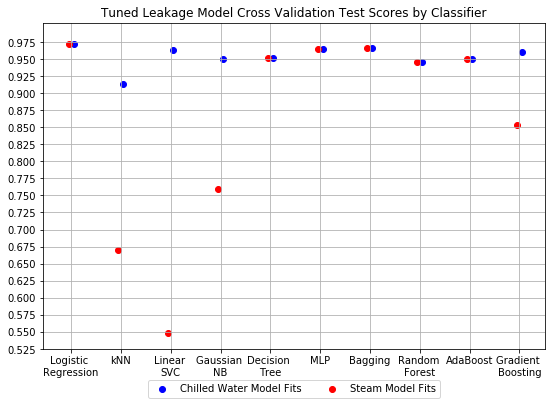

In [113]:
N = 10

fig1, ax1 = plt.subplots(figsize=(9,6))

ind = np.arange(N)    # the x locations for the groups
p1 = ax1.scatter(ind+0.05, chw_tuned_scores, color='blue')
p2 = ax1.scatter(ind-0.05, stm_tuned_scores, color='red')

ax1.set_title('Tuned Leakage Model Cross Validation Test Scores by Classifier')
ax1.set_xticks(ind)
ax1.set_yticks(np.arange(0.5, 1, 0.025))
ax1.set_xticklabels(('Logistic \nRegression', 'kNN', 'Linear \nSVC', 'Gaussian \nNB', 'Decision \nTree','MLP', 
                     'Bagging', 'Random \nForest', 'AdaBoost', 'Gradient \nBoosting'))

ax1.legend((p1, p2), ('Chilled Water Model Fits', 'Steam Model Fits'), loc='upper center', 
           bbox_to_anchor=(0.5, -0.08), fancybox=True, ncol=2)
ax1.autoscale_view()

plt.grid(True)
plt.show()

In [4]:
chw_tuned_scores_good = [0.9726031429745859, 0.9509725157013511, 0.9645480085640272, 0.966302107414968, 0.9454986402748486, 0.9495214105596675]
stm_tuned_scores_good = [0.9726031429745859, 0.9509725157013511, 0.9645480085640272, 0.966302107414968, 0.9454986402748486, 0.9495214105596675]

print(chw_tuned_scores_good)
print(stm_tuned_scores_good)

[0.9726031429745859, 0.9509725157013511, 0.9645480085640272, 0.966302107414968, 0.9454986402748486, 0.9495214105596675]
[0.9726031429745859, 0.9509725157013511, 0.9645480085640272, 0.966302107414968, 0.9454986402748486, 0.9495214105596675]


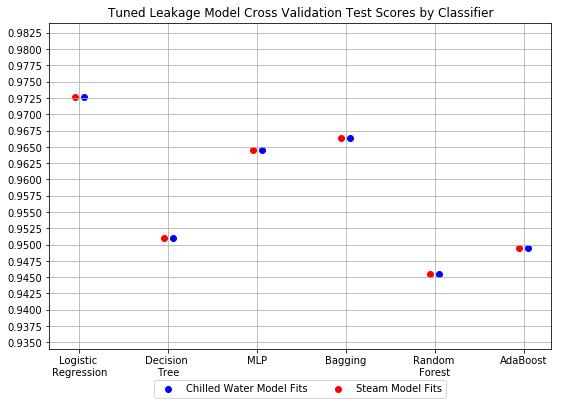

In [7]:
N = 6

fig1, ax1 = plt.subplots(figsize=(9,6))

ind = np.arange(N)    # the x locations for the groups
p1 = ax1.scatter(ind+0.05, chw_tuned_scores_good, color='blue')
p2 = ax1.scatter(ind-0.05, stm_tuned_scores_good, color='red')

ax1.set_title('Tuned Leakage Model Cross Validation Test Scores by Classifier')
ax1.set_xticks(ind)
ax1.set_yticks(np.arange(0.925, 1, 0.0025))
ax1.set_xticklabels(('Logistic \nRegression', 'Decision \nTree', 'MLP', 
                     'Bagging', 'Random \nForest', 'AdaBoost'))

ax1.legend((p1, p2), ('Chilled Water Model Fits', 'Steam Model Fits'), loc='upper center', 
           bbox_to_anchor=(0.5, -0.08), fancybox=True, ncol=2)
ax1.autoscale_view()

plt.grid(True)
plt.show()

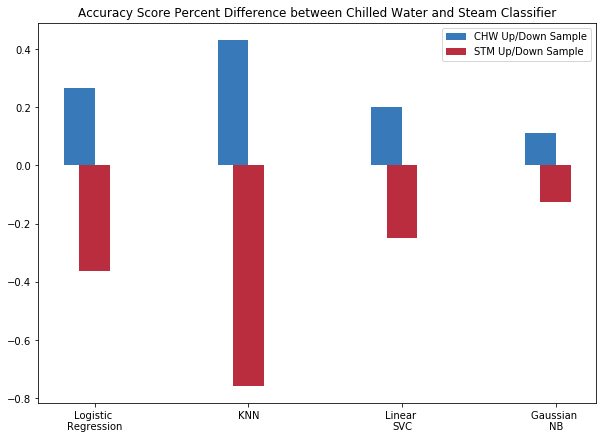

In [119]:
# Plot differences in accuracy between chw and stm models
tune_model_diff_chw = []
tune_model_diff_stm = []

for i in [1,2,3,9]:
    tune_model_diff_chw.append((chw_tuned_scores[i]-stm_tuned_scores[i])/chw_tuned_scores[i])
    tune_model_diff_stm.append((stm_tuned_scores[i]-chw_tuned_scores[i])/stm_tuned_scores[i])

N = 4

fig, ax = plt.subplots(figsize=(10,7))

ind = np.arange(N)    # the x locations for the groups
width = 0.2         # the width of the bars
p1 = ax.bar(ind, tune_model_diff_chw, width, color='#3779b9', bottom=0)
p2 = ax.bar(ind + width/2, tune_model_diff_stm, width, color='#ba2d3e', bottom=0)

ax.set_title('Accuracy Score Percent Difference between Chilled Water and Steam Classifier')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('kNN', 'Linear \nSVC', 'Gaussian \nNB', 'Decision \nTree',
                    'MLP', 'Bagging', 'Random \nForest', 'AdaBoost', 'Gradient \nBoosting'))

ax.autoscale_view()

plt.show()

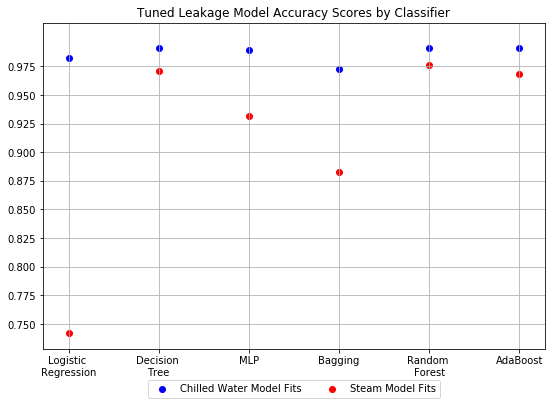

In [13]:
chw_gs_acc_scores = [0.9819199112179784,0.9910755571996671,0.9895958568389901,
0.9726255433274762,0.9910755571996671,0.9910755571996671]

stm_gs_acc_scores = [0.7417411333148499,0.9706221075305509,0.9315511100684596,
0.8829256328776472,0.9765829938791615,0.9685000746443729]

N = 6

fig1, ax1 = plt.subplots(figsize=(9,6))

ind = np.arange(N)    # the x locations for the groups
p1 = ax1.scatter(ind, chw_gs_acc_scores, color='blue')
p2 = ax1.scatter(ind, stm_gs_acc_scores, color='red')

ax1.set_title('Tuned Leakage Model Accuracy Scores by Classifier')
ax1.set_xticks(ind)
ax1.set_yticks(np.arange(0.5, 1, 0.025))
ax1.set_xticklabels(('Logistic \nRegression', 'Decision \nTree', 'MLP', 
                     'Bagging', 'Random \nForest', 'AdaBoost'))

ax1.legend((p1, p2), ('Chilled Water Model Fits', 'Steam Model Fits'), loc='upper center', 
           bbox_to_anchor=(0.5, -0.08), fancybox=True, ncol=2)
ax1.autoscale_view()

plt.grid(True)
plt.show()


In [ ]:
final_predict_chw = chw_bag_cv.predict(X_chw_test)
final_predict_stm = stm_bag_cv.predict(X_stm_test)

In [ ]:
print(final_predict_chw)
print(final_predict_stm)

In [ ]:
print(Y_chw_test)
print(Y_stm_test)

## Final Model
### Random Forest

In [ ]:
# chw_model = stm_model = ensemble.BaggingClassifier()
# chw_model.fit(X_chw_train, Y_chw_train)
# stm_model.fit(X_stm_train, Y_stm_train)

# chw_pred = chw_model.predict(X_chw_test)
# stm_pred = stm_model.predict(X_stm_test)

# chw_acc_score = accuracy_score(Y_chw_test, chw_pred)
# stm_acc_score = accuracy_score(Y_stm_test, stm_pred)

# np.random.seed(1004)
# cmap_data = plt.cm.Paired
# cmap_cv = plt.cm.coolwarm
# n_splits = 5

# chw_cv = cross_validate(chw_model, X_chw_train, Y_chw_train, scoring = 'precision_macro', cv = 5)
# stm_cv = cross_validate(stm_model, X_stm_train, Y_stm_train, scoring = 'precision_macro', cv = 5)

# chw_test_score = np.mean(chw_cv['test_score'])
# stm_test_score = np.mean(stm_cvs[i]['test_score'])

In [12]:
chw_dt = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=30,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

stm_dt = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

chw_dt.fit(X_chw_train, Y_chw_train)
stm_dt.fit(X_stm_train, Y_stm_train)

chw_dt_pred = chw_dt.predict(X_chw_test)
stm_dt_pred = stm_dt.predict(X_stm_test)

chw_dt_acc = accuracy_score(Y_chw_test, chw_dt_pred)
stm_dt_acc = accuracy_score(Y_stm_test, stm_dt_pred)

print('CHW Tuned Decision Trees Accuracy Score:', chw_dt_acc, '\n',
     'STM Tuned Decision Trees Accuracy Score:', stm_dt_acc, '\n')

print(confusion_matrix(Y_chw_test, chw_dt_pred),'\n',
confusion_matrix(Y_stm_test, stm_dt_pred))

CHW Tuned Decision Trees Accuracy Score: 0.9887635253861093 
 STM Tuned Decision Trees Accuracy Score: 0.9705581266395104 

[[13061   162]
 [   81  8322]] 
 [[50745  1356]
 [ 1405 40272]]


In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict

In [14]:
chw_y_probs_dt = cross_val_predict(chw_dt, X_chw_train, Y_chw_train, cv=5, method='predict_proba')
stm_y_probs_dt = cross_val_predict(stm_dt, X_stm_train, Y_stm_train, cv=5, method='predict_proba')

In [15]:
chw_y_scores_dt = chw_y_probs_dt[:,1]
stm_y_scores_dt = stm_y_probs_dt[:,1]

chw_fpr_dt, chw_tpr_dt, chw_thresholds_dt = roc_curve(Y_chw_train, chw_y_scores_dt)
stm_fpr_dt, stm_tpr_dt, stm_thresholds_dt = roc_curve(Y_stm_train, stm_y_scores_dt)

In [16]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('False Negative Rate')

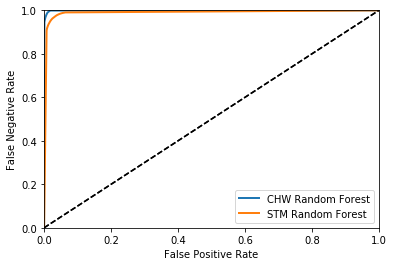

In [17]:
plot_roc_curve(chw_fpr_dt, chw_tpr_dt, "CHW Random Forest")
plot_roc_curve(stm_fpr_dt, stm_tpr_dt, "STM Random Forest")
plt.legend(loc="lower right")
plt.show()

In [35]:
roc_auc_score(Y_chw_train, chw_y_scores_rf)

0.9994149990886152

In [36]:
roc_auc_score(Y_stm_train, stm_y_scores_rf)

0.9971822055823157

Confusion matrix, without normalization
[[13061   162]
 [   81  8322]]


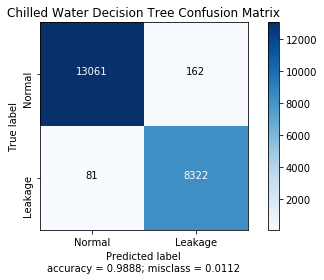

In [21]:
chw_dt_cm = confusion_matrix(Y_chw_test, chw_dt_pred)

# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(chw_dt_cm, classes=['Normal','Leakage'],normalize=False,
                      title='Chilled Water Decision Tree Confusion Matrix')

plt.show()

Confusion matrix, without normalization
[[50745  1356]
 [ 1405 40272]]


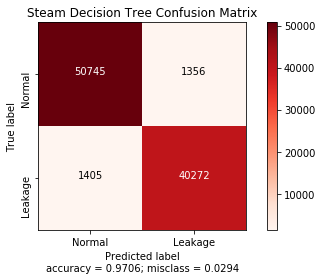

In [23]:
stm_dt_cm = confusion_matrix(Y_stm_test, stm_dt_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(stm_dt_cm, classes=['Normal','Leakage'],normalize=False,
                      title='Steam Decision Tree Confusion Matrix',cmap=plt.cm.Reds)

plt.show()

In [16]:
print(chw_rf_pred)
print(stm_rf_pred)

print(Y_chw_test)
print(Y_stm_test)

0.9888560066586516
0.9770948410074858
33414     Leakage
3475      Leakage
10945     Leakage
85248     Leakage
6113      Leakage
76323      Normal
32720     Leakage
75600      Normal
13650     Leakage
32741     Leakage
21633     Leakage
82168      Normal
22293     Leakage
24959      Normal
39695     Leakage
16348     Leakage
7858      Leakage
29718      Normal
20757     Leakage
79678     Leakage
54289      Normal
37241     Leakage
94099      Normal
1567      Leakage
58815      Normal
53668      Normal
60559      Normal
8291      Leakage
106143    Leakage
18579     Leakage
           ...   
26979     Leakage
27814     Leakage
65383      Normal
4548      Leakage
2832      Leakage
79685      Normal
106246    Leakage
104434    Leakage
81259      Normal
78582      Normal
107137     Normal
102025    Leakage
84797      Normal
52130      Normal
64203      Normal
58351      Normal
35743     Leakage
74431      Normal
22449     Leakage
80803      Normal
40381     Leakage
101613    Leakage
54135   